# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy as np
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

#### 1.1 Data loading

In [3]:
data_from_json = "mini_sparkify_event_data.json"
spark_dataframe = spark.read.json(data_from_json)

#### 1.2. Checking dataframe size

In [4]:
spark_dataframe.toPandas().shape

(286500, 18)

The dataframes has 286 500 rows and 18 columns.

#### 1.3. Checking null values.

In [29]:
for column in spark_dataframe.columns:
    null_count = spark_dataframe.filter(spark_dataframe[column].isNull()).count()
    if null_count != 0:
        print(f'The count of null values in the column {column} = {null_count}')

The count of null values in the column artist = 58392
The count of null values in the column firstName = 8346
The count of null values in the column gender = 8346
The count of null values in the column lastName = 8346
The count of null values in the column length = 58392
The count of null values in the column location = 8346
The count of null values in the column registration = 8346
The count of null values in the column song = 58392
The count of null values in the column userAgent = 8346


We can see that columns 'firstName' and 'LastName' have 8346 null values. Furthermore, the column 'userAgent' includes the 8346 null values too.
Nevertheless, the column 'userId' has not null values. We have to check the column 'userId' on invalid data, like an empty row.

In [30]:
spark_dataframe.where(spark_dataframe["userId"]== '').count()

8346

The same 8346 rows. Try to display one of them.

In [31]:
spark_dataframe.where(spark_dataframe["userId"]== '').show(1, vertical=True, truncate=False)

-RECORD 0----------------------
 artist        | null          
 auth          | Logged Out    
 firstName     | null          
 gender        | null          
 itemInSession | 100           
 lastName      | null          
 length        | null          
 level         | free          
 location      | null          
 method        | GET           
 page          | Home          
 registration  | null          
 sessionId     | 8             
 song          | null          
 status        | 200           
 ts            | 1538355745000 
 userAgent     | null          
 userId        |               
only showing top 1 row



We can see the 'Logged Out' value in the 'auth' column where the 'userId' column value is an empty row.

What the values does  the 'auth' column include, except 'Logged Out'?

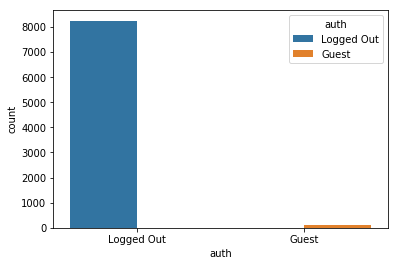

In [32]:
# Auth's values bar plot
auth_to_plot = spark_dataframe.select("auth").where(spark_dataframe["userId"]== '') \
.groupBy("auth").count().toPandas()
sns.barplot(x='auth', y='count', hue='auth', data=auth_to_plot)

The plot show us that the 'auth' column consists of the 'Logged Out' and the 'Guest' values. 

We can drop all rows with the 'Logged Out' and the 'Guest' values due to these rows are the audit records and have not the information about a user churn or any user activity.

In [4]:
# drop all rows with the 'Logged Out' and the 'Guest' values
spark_dataframe = spark_dataframe.filter(spark_dataframe["userId"] != '')

In [64]:
# checking null values again
for column in spark_dataframe.columns:
    null_count = spark_dataframe.filter(spark_dataframe[column].isNull()).count()
    if null_count != 0:
        print(f'The count of null values in the column {column} = {null_count}')

The count of null values in the column artist = 50046
The count of null values in the column length = 50046
The count of null values in the column song = 50046


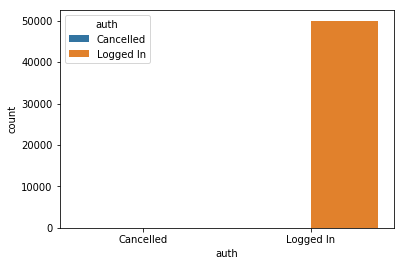

In [36]:
# Auth's values bar plot
auth_to_plot = spark_dataframe.select("auth").where(spark_dataframe["artist"].isNull()) \
.groupBy("auth").count().toPandas()
sns.barplot(x='auth', y='count', hue='auth', data=auth_to_plot)

The most of audit records are the 'Logged In'. We can suppose that users jumped from a page to page.

Do a check.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

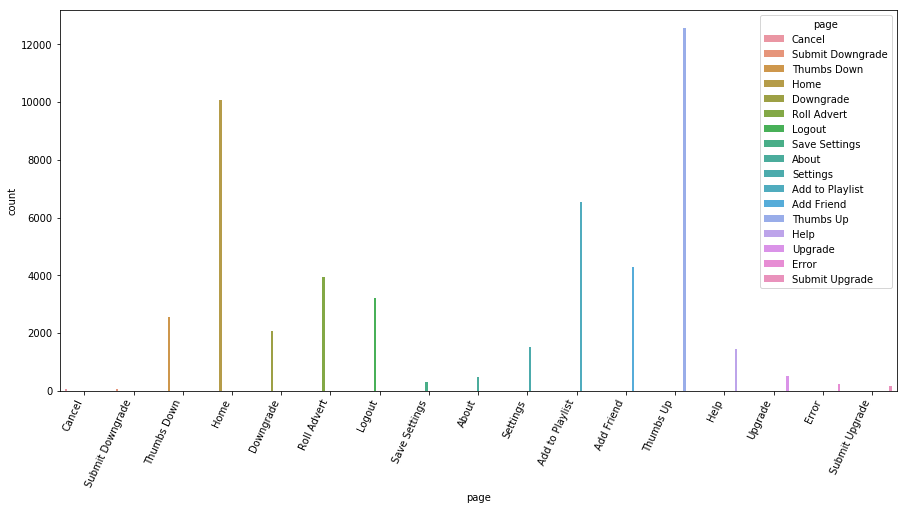

In [46]:
users_jumping = spark_dataframe.select("page").where(spark_dataframe["auth"]== 'Logged In') \
.where(spark_dataframe["artist"].isNull()) \
.groupBy("page").count().toPandas()

plt.figure(figsize=(15,7))
users_jumping = sns.barplot(x='page', y='count', hue='page', data=users_jumping)
plt.xticks(rotation=65, horizontalalignment='right')

The plot reveals several users activity. We can drop the rows with the 'Logged In' value, but we could lost some information about users activity.

# Exploratory Data Analysis


### Define Churn

Let show one of the rows.

In [14]:
spark_dataframe.show(1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA                                                          
 method        | PUT                                                                      

The record display that the user Colin Freeman listened the song Rockpools by Martha Tilston.
The dataframe is not a dataset. It is a part of log file. This datafame does not consist of any features could be using for prediction directly.

All of the dataframe columns are using to describe a user or a user action.

We can see the 18th columns in the dataframe and we have to determine which column contains the information about user churn.
Actually, the columns listed below include information about:
* artist - a singer name or a group name;
* firstName - a user first name;
* gender - a user gender;
* itemInSession - some identificator or count;
* lastName - a user last name;
* length - in this case a length of a user sessions or a duration of the song;
* level - a free or paid account status;
* location - a user location;
* method - a http method;
* registration - a user registraion date;
* sessionId - a user session identificatior;
* song - a song name;
* status - a request status code response;
* ts - a user session timestamp;
* userAgent - a user browser type;
* userId - a user registration identificatior.

We have to explore auth and page columns.

In [7]:
# The exact 'auth' values
spark_dataframe.select("auth").groupBy("auth").count()

auth,count
Cancelled,52
Logged In,278102


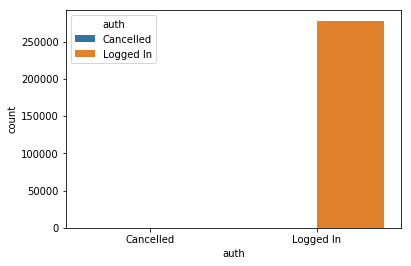

In [8]:
# 'auth's values bar plot
auth_to_plot = spark_dataframe.select("auth").groupBy("auth").count().toPandas()
sns.barplot(x='auth', y='count', hue='auth', data=auth_to_plot)

In [24]:
# The exact 'page' values
spark_dataframe.select("page").groupBy("page").count().show(100, truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |14457 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |924   |
|Submit Registration      |5     |
|Settings                 |1514  |
|Login                    |3241  |
|Register                 |18    |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1726  |
|Upgrade                  |499   |
|Error                    |258   |
|Submit Upgrade           |159   |
+-------------------------+------+



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

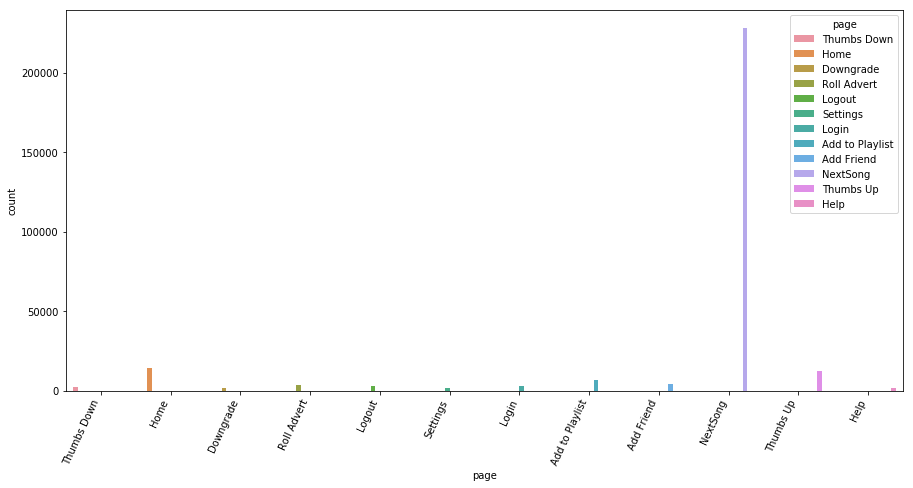

In [22]:
# 'page's value bar plot
# with visiting count over 1000
page_to_plot_above_1000 = spark_dataframe.select("page") \
.groupBy("page").count() \
.where(col("count") > 1000).toPandas() 

plt.figure(figsize=(15,7))
page = sns.barplot(x='page', y='count', hue='page', data=page_to_plot_above_1000)
plt.xticks(rotation=65, horizontalalignment='right')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

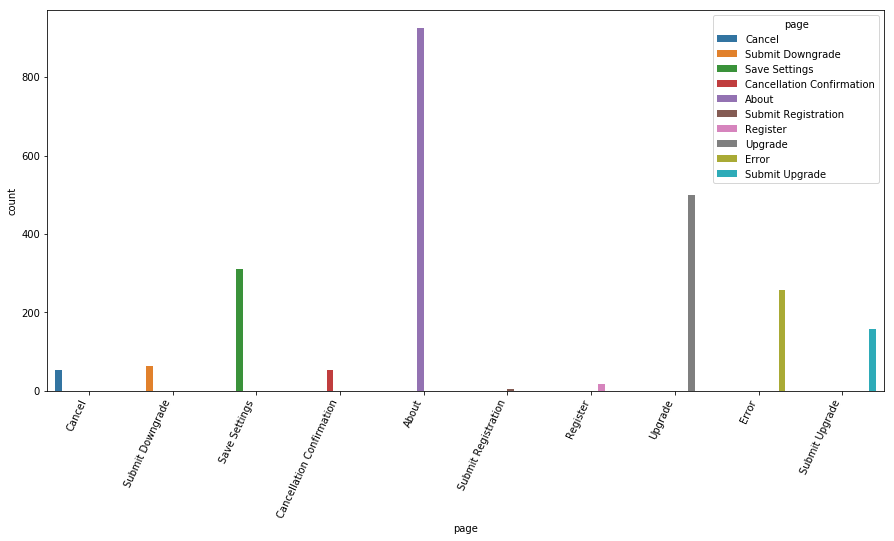

In [23]:
# 'page's value bar plot
# with visiting count less or equal 1000
page_to_plot_below_1000 = spark_dataframe.select("page") \
.groupBy("page").count() \
.where(col("count") <= 1000).toPandas() 

plt.figure(figsize=(15,7))
sns.barplot(x='page', y='count', hue='page', data=page_to_plot_below_1000)
plt.xticks(rotation=65, horizontalalignment='right')

The visiting counts of the 'Cancel' and 'Cancellation Confirmation' are 52. Let show 'userId'.

In [16]:
spark_dataframe.select("auth", "userId", "page").filter(spark_dataframe["page"] == "Cancellation Confirmation") \
.groupBy("auth", "userId", "page").count() \
.orderBy("userId").show(1000, truncate=False)

+---------+------+-------------------------+-----+
|auth     |userId|page                     |count|
+---------+------+-------------------------+-----+
|Cancelled|100001|Cancellation Confirmation|1    |
|Cancelled|100003|Cancellation Confirmation|1    |
|Cancelled|100005|Cancellation Confirmation|1    |
|Cancelled|100006|Cancellation Confirmation|1    |
|Cancelled|100007|Cancellation Confirmation|1    |
|Cancelled|100009|Cancellation Confirmation|1    |
|Cancelled|100011|Cancellation Confirmation|1    |
|Cancelled|100012|Cancellation Confirmation|1    |
|Cancelled|100013|Cancellation Confirmation|1    |
|Cancelled|100014|Cancellation Confirmation|1    |
|Cancelled|100015|Cancellation Confirmation|1    |
|Cancelled|100017|Cancellation Confirmation|1    |
|Cancelled|100019|Cancellation Confirmation|1    |
|Cancelled|100021|Cancellation Confirmation|1    |
|Cancelled|100022|Cancellation Confirmation|1    |
|Cancelled|100023|Cancellation Confirmation|1    |
|Cancelled|100024|Cancellation 

All users who visited the 'Cancellation Confirmation' page have being obtained the 'Cancelled' value in the column 'auth'.

The 'Cancellation Confirmation' is a label to define churn.

### Explore Data

#### The target column.

As noted above, the dataframe is a part of logfile.
Let aggregate the data.

Firstly, we can create a new column with 'Churn'. Our target.

In [5]:
churn_userId_dataframe = spark_dataframe.select("userId").filter(spark_dataframe["auth"] == "Cancelled")
churned_users_list = [row['userId'] for row in churn_userId_dataframe.collect()]

In [6]:
# creating function to apply it on dataframe
isChurn = udf(lambda x: 1 if x in churned_users_list else 0, IntegerType())
spark_dataframe = spark_dataframe.withColumn('isChurn', isChurn("userId"))

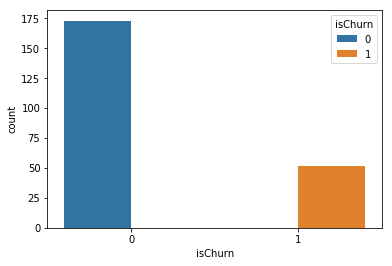

In [7]:
# plotting the result of applying function
userId_to_plot = spark_dataframe.dropDuplicates(["userId","isChurn"]) \
.groupby(["isChurn"]).count().toPandas()
sns.barplot(x="isChurn", y="count", hue="isChurn", data=userId_to_plot)

In [9]:
spark_dataframe.dropDuplicates(["userId","isChurn"]) \
.groupby(["gender", "isChurn"]).count()

gender,isChurn,count
M,1,32
F,0,84
F,1,20
M,0,89


In [7]:
# the exact 'isChurn' values
spark_dataframe.select("isChurn").groupBy("isChurn").count()

isChurn,count
1,52
0,278102


#### Users count

Next step is to calculate the distinct users in the dataframe.

In [32]:
spark_dataframe.select("userId").distinct().count()

225

#### Explore the 'gender' column.

Now, the 'gender' column.

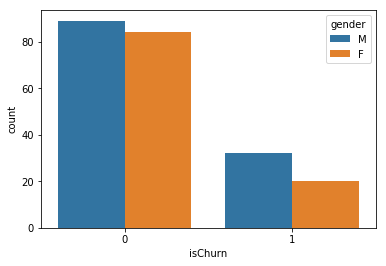

In [10]:
# plotting a gender of all the distinct users
gender_to_plot = spark_dataframe.select("userId", "gender", "isChurn").distinct() \
.groupby(['gender','isChurn']).count().toPandas()
sns.barplot(x="isChurn", y="count", hue="gender", data=gender_to_plot)

In [11]:
# the exact 'gender' values
spark_dataframe.select("userId", "gender", "isChurn").distinct().groupby(['gender','isChurn']).count()

gender,isChurn,count
M,1,32
F,0,84
F,1,20
M,0,89


The 'gender' column has categorical data. The values are 'F' and 'M', female and male respectively.

#### Explore the 'level' column

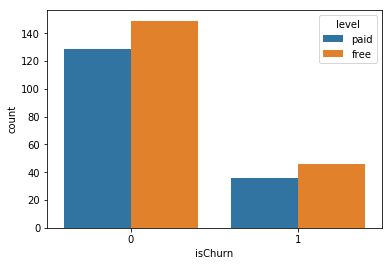

In [12]:
level_to_plot = spark_dataframe.select("userId", "level", "isChurn").distinct() \
.groupby(['level','isChurn']).count().toPandas()
sns.barplot(x="isChurn", y="count", hue="level", data=level_to_plot)

The 'level' column has categorical data. The values are 'paid' and 'free'.

We have a problem. As we remember the total count of users is 225.

The plot shows the grouped data by the 'level' column and all user's count more than 225.
Out dataframe is a log file. Each user could change his(er) account to paid or free more than once.
We have to group the data in the 'level' column and select the records with the maximum timestamp.

In [7]:
# create an additional dataframe consisted of the distinct 'userId' values and the maximum timestamp for each user.
max_ts_dataframe = spark_dataframe.groupby("userId").agg({"ts": "max"}).orderBy("userId")

# create a conditional to join the max_ts_dataframe and the spark_dataframe
conditional = [spark_dataframe["ts"] == max_ts_dataframe["max(ts)"],
               spark_dataframe["userId"] == max_ts_dataframe["userId"]]

# join out dataframes to create a dataframe with the maximum timestamps.
level_with_max_ts_dataframe = spark_dataframe.join(max_ts_dataframe, conditional, 'leftsemi')

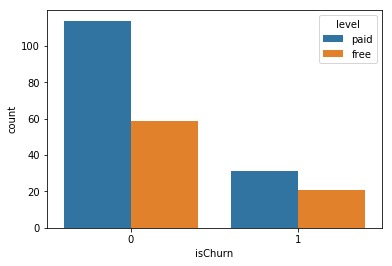

In [15]:
# ploting the grouped 'level' agian
level_to_plot = level_with_max_ts_dataframe \
.select("userId", "level", "isChurn").distinct() \
.groupby(['level','isChurn']).count().toPandas()

sns.barplot(x="isChurn", y="count", hue="level", data=level_to_plot)

In [25]:
# check the exact grouped 'level'
level_with_max_ts_dataframe.toPandas().shape

(227, 19)

Rows (distinct users) count is 227, not 225.

In [17]:
# inspect duplicates timestamps
level_with_max_ts_dataframe.select("userId", 'ts') \
.groupBy("userId", 'ts').count().where(col("count") > 1)

userId,ts,count
125,1539318918000,2
127,1543351229000,2


In [13]:
level_with_max_ts_dataframe.select("userId", "page", "ts") \
.where(col("userId") == 125)

userId,page,ts
125,Cancel,1539318918000
125,Cancellation Conf...,1539318918000


In [14]:
level_with_max_ts_dataframe.select("userId", "page", "ts") \
.where(col("userId") == 127)

userId,page,ts
127,NextSong,1543351229000
127,Home,1543351229000


The user's with Id 125 and 127 performed two actions at the same time. The timestamps are identical. In respect that we have only two users, we should not consider them.

#### Explore the 'page' column

In [24]:
# the exact 'page' values
spark_dataframe.select("page").groupBy("page").count().show(100, truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



The users visited the different pages. Not all of the visited pages influence on the user desicion to churn. Let create a list with the pages affected on the desicion.

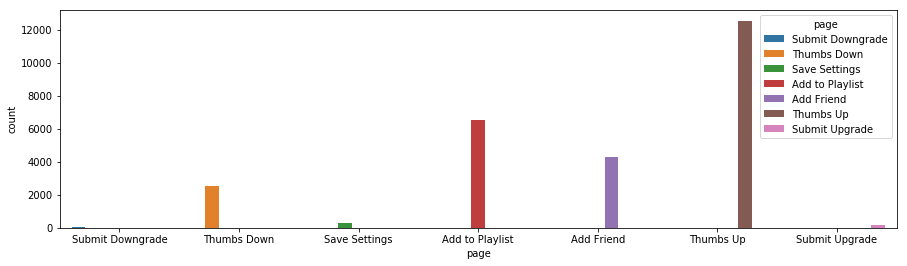

In [22]:
pages_list = ['Submit Downgrade', 'Thumbs Down', 'Save Settings',
             'Add to Playlist', 'Add Friend', 'Thumbs Up', 'Submit Upgrade']

significant_pages_to_plot = spark_dataframe.select("page").filter(col("page").isin(pages_list)) \
.groupBy("page").count().toPandas()

plt.figure(figsize=(15,4))
sns.barplot(x="page", y="count", hue="page", data=significant_pages_to_plot)

In [26]:
# the exat values of the pages affected on the desicion
spark_dataframe.select("page", 'isChurn').filter(col("page").isin(pages_list)) \
.groupBy("page", "isChurn").count().orderBy("page", "isChurn")

page,isChurn,count
Add Friend,0,3641
Add Friend,1,636
Add to Playlist,0,5488
Add to Playlist,1,1038
Save Settings,0,252
Save Settings,1,58
Submit Downgrade,0,54
Submit Downgrade,1,9
Submit Upgrade,0,127
Submit Upgrade,1,32


The users did not cancel a subscription visited more times the pages 'Add Friend', 'Add to Playlist', 'Save Settings', 'Submit Upgrade', 'Thumbs Up'.

#### Explore the userAgent' column.

This column describe a browser using to read the pages. We can calculate the distinct browsers.

In [28]:
spark_dataframe.select("userAgent").distinct().count()

56

Listing a few of them.

In [44]:
spark_dataframe.select("userAgent").distinct().show(5)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 5 rows



#### Explore the 'location' column.

The column consist of the information about user location durin the user session.

In [45]:
spark_dataframe.select("location").distinct().count()

114

Total users location is 114.

In [47]:
spark_dataframe.select("location").show(5, truncate=False)

+------------------------------+
|location                      |
+------------------------------+
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
+------------------------------+
only showing top 5 rows



#### Explore the 'method' column.

This column has categorical data of two http methods 'PUT' and 'GET'.

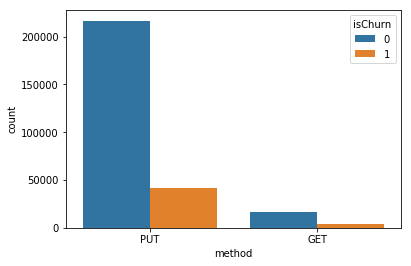

In [48]:
# plotting the 'method' values
sns.countplot(x='method', hue='isChurn', data=spark_dataframe.toPandas())

In [53]:
# the exact 'method' values
spark_dataframe.select("method", "isChurn").groupBy("method", "isChurn").count() \
.orderBy("method", "isChurn")

method,isChurn,count
GET,0,16599
GET,1,3737
PUT,0,216691
PUT,1,41127


#### Explore the 'status' column.

The column consisted of the categorical data too. There are the request status codes in the column.

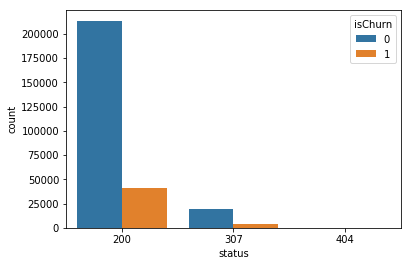

In [51]:
# plotting the 'status' values
sns.countplot(x='status', hue='isChurn', data=spark_dataframe.toPandas())

In [55]:
# the exact 'status' values
spark_dataframe.select("status", "isChurn").groupBy("status", "isChurn").count() \
.orderBy("status", "isChurn")

status,isChurn,count
200,0,213581
200,1,41137
307,0,19489
307,1,3695
404,0,220
404,1,32


#### Explore columns 'registration' and 'ts'.

The columns have the timestamps data. Column 'registration' is the date of users registration. Column 'ts' is the date of users sessions.

In [57]:
spark_dataframe.select("userId", "ts").show(5)

+------+-------------+
|userId|           ts|
+------+-------------+
|    30|1538352117000|
|     9|1538352180000|
|    30|1538352394000|
|     9|1538352416000|
|    30|1538352676000|
+------+-------------+
only showing top 5 rows



In [58]:
spark_dataframe.select("userId", "registration").show(5)

+------+-------------+
|userId| registration|
+------+-------------+
|    30|1538173362000|
|     9|1538331630000|
|    30|1538173362000|
|     9|1538331630000|
|    30|1538173362000|
+------+-------------+
only showing top 5 rows



#### Explore columns 'artist' and 'song'.

These columns have information about songs and artists.

In [59]:
spark_dataframe.select("artist").distinct().count()

17656

In [60]:
spark_dataframe.select("song").distinct().count()

58481

The columng have too many different values.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Create a dataframe with unique users record.

In [8]:
churn_dataframe = level_with_max_ts_dataframe.select("userId", "gender", "level", "isChurn").dropDuplicates()

#### Categorical features handling.

Create two column to handle the catecorical values in the 'gender' column.

In [9]:
# create isMale column
isMale = udf(lambda x: 1 if x =='M' else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('isMale', isMale("gender"))

# create isFemale column
isFemale = udf(lambda x: 1 if x =='F' else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('isFemale', isFemale("gender"))

The 'level' column has a catecorical feature too. Handle it.

In [10]:
# create isPaid column
isPaid = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('isPaid', isPaid("level"))

# create isFree column
isFree = udf(lambda x: 1 if x =='free' else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('isFree', isFree("level"))

#### Numerical features.

Each user has different count of listened song, completed sessions. 

In [52]:
spark_dataframe.select("userId", "song", "isChurn") \
.groupBy("userId", "isChurn").agg({"song": "count"}) \
.orderBy("userId").show(5)

+------+-------+-----------+
|userId|isChurn|count(song)|
+------+-------+-----------+
|    10|      0|        673|
|   100|      0|       2682|
|100001|      1|        133|
|100002|      0|        195|
|100003|      1|         51|
+------+-------+-----------+
only showing top 5 rows



In [54]:
spark_dataframe.select("userId", "sessionId", "isChurn").distinct() \
.groupBy("userId", "isChurn").agg({"sessionId": "count"}) \
.orderBy("userId").show(5)

+------+-------+----------------+
|userId|isChurn|count(sessionId)|
+------+-------+----------------+
|    10|      0|               6|
|   100|      0|              35|
|100001|      1|               4|
|100002|      0|               4|
|100003|      1|               2|
+------+-------+----------------+
only showing top 5 rows



We should create columns contained of users listened songs and completed sessions. These columns describe the users activity. We can call the columns as the first part users activity.

In [11]:
# creating a pandas dataframe with count of songs listened by users
users_songs = spark_dataframe.filter(spark_dataframe["song"].isNotNull()) \
.select("userId", "song").groupBy("userId").count().orderBy("userId").toPandas()

# creatting a pandas dataframe with count of users sessions
users_sessions = spark_dataframe.select("userId", "sessionId").distinct() \
.groupBy("userId").count().orderBy("userId").toPandas()

In [12]:
# creating songsPerUser column
songsPerUser = udf(lambda x: int(users_songs["count"][users_songs['userId'] == x]), IntegerType())
churn_dataframe = churn_dataframe.withColumn('songsPerUser', songsPerUser("userId"))

# creating sessionsPerUser column
sessionsPerUser = udf(lambda x: int(users_sessions["count"][users_sessions['userId'] == x]), IntegerType())
churn_dataframe = churn_dataframe.withColumn('sessionsPerUser', sessionsPerUser("userId"))

The second part users activity are the visited pages. As we saw earlier the users did not cancel a subscription visited more times the pages 'Add Friend', 'Add to Playlist', 'Save Settings', 'Submit Upgrade', 'Thumbs Up'.

We can create some columns to store information about users activity on the pages.

Firstly, we create several pandas dataframes with count of visited pages.

In [13]:
# creating a pandas dataframe with count of visited Submit Downgrade page by user
users_visited_Submit_Downgrade = spark_dataframe.filter(col("page") == 'Submit Downgrade') \
.select("userId", "page") \
.groupBy("userId").count().orderBy("userId").toPandas()

# creating a pandas dataframe with count of visited Thumbs Down page by user
users_visited_Thumbs_Down = spark_dataframe.filter(col("page") == 'Thumbs Down') \
.select("userId", "page") \
.groupBy("userId").count().orderBy("userId").toPandas()

# creating a pandas dataframe with count of visited Save Settings page by user
users_visited_Save_Settings = spark_dataframe.filter(col("page") == 'Save Settings') \
.select("userId", "page") \
.groupBy("userId").count().orderBy("userId").toPandas()

# creating a pandas dataframe with count of visited Add to Playlist page by user
users_visited_Add_to_Playlist = spark_dataframe.filter(col("page") == 'Add to Playlist') \
.select("userId", "page") \
.groupBy("userId").count().orderBy("userId").toPandas()

# creating a pandas dataframe with count of visited Add Friend page by user
users_visited_Add_Friend = spark_dataframe.filter(col("page") == 'Add Friend') \
.select("userId", "page") \
.groupBy("userId").count().orderBy("userId").toPandas()

# creating a pandas dataframe with count of visited Thumbs Up page by user
users_visited_Thumbs_Up = spark_dataframe.filter(col("page") == 'Thumbs Up') \
.select("userId", "page") \
.groupBy("userId").count().orderBy("userId").toPandas()

# creating a pandas dataframe with count of visited Submit Upgrade page by user
users_visited_Submit_Upgrade = spark_dataframe.filter(col("page") == 'Submit Upgrade') \
.select("userId", "page") \
.groupBy("userId").count().orderBy("userId").toPandas()

Secondly, we create the columns with agregated data in the spark dataframe.

In [14]:
# creating countSD column
countSD = udf(lambda x: int(users_visited_Submit_Downgrade["count"] \
                            [users_visited_Submit_Downgrade["userId"] == str(x)]) \
                        if users_visited_Submit_Downgrade[users_visited_Submit_Downgrade["userId"] == x].shape[0] != 0 \
                        else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn("countSD", countSD("userId"))

# creating countTD column
countTD = udf(lambda x: int(users_visited_Thumbs_Down["count"] \
                            [users_visited_Thumbs_Down["userId"] == str(x)]) \
                        if users_visited_Thumbs_Down[users_visited_Thumbs_Down["userId"] == x].shape[0] != 0 \
                        else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('countTD', countTD("userId"))

# creating countSS column
countSS = udf(lambda x: int(users_visited_Save_Settings["count"] \
                            [users_visited_Save_Settings["userId"] == str(x)]) \
                        if users_visited_Save_Settings[users_visited_Save_Settings["userId"] == x].shape[0] != 0 \
                        else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('countSS', countSS("userId"))

# creating countAP column
countAP = udf(lambda x: int(users_visited_Add_to_Playlist["count"] \
                            [users_visited_Add_to_Playlist["userId"] == str(x)]) \
                        if users_visited_Add_to_Playlist[users_visited_Add_to_Playlist["userId"] == x].shape[0] != 0 \
                        else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('countAP', countAP("userId"))

# creating countAF column
countAF = udf(lambda x: int(users_visited_Add_Friend["count"] \
                            [users_visited_Add_Friend["userId"] == str(x)]) \
                        if users_visited_Add_Friend[users_visited_Add_Friend["userId"] == x].shape[0] != 0 \
                        else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('countAF', countAF("userId"))

# creating countTU column
countTU = udf(lambda x: int(users_visited_Thumbs_Up["count"] \
                            [users_visited_Thumbs_Up["userId"] == str(x)]) \
                        if users_visited_Thumbs_Up[users_visited_Thumbs_Up["userId"] == x].shape[0] != 0 \
                        else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('countTU', countTU("userId"))

# creating countSU column
countSU = udf(lambda x: int(users_visited_Submit_Upgrade["count"] \
                            [users_visited_Submit_Upgrade["userId"] == str(x)]) \
                        if users_visited_Submit_Upgrade[users_visited_Submit_Upgrade["userId"] == x].shape[0] != 0 \
                        else 0, IntegerType())
churn_dataframe = churn_dataframe.withColumn('countSU', countSU("userId"))

Thirdly, we recreate the spark dataframe and drop columns with raw categorical data.

In [15]:
churn_dataframe = churn_dataframe.select("userId", "isMale", "isFemale", "isPaid",
                                        "isFree", "songsPerUser", "sessionsPerUser",
                                        "countSD", "countTD", "countSS", "countAP",
                                        "countAF", "countTU", "countSU", "isChurn")

The final size of the spark dataframe.

In [18]:
churn_dataframe.toPandas().shape

(225, 15)

# Modeling


We create a feature vector.

In [16]:
assembler = VectorAssembler(inputCols = churn_dataframe.columns[1:-1], outputCol = "featuresVector")

And add the vector to a new spark dataframe.

In [17]:
data = assembler.transform(churn_dataframe)

We have to standardize the data.

In [18]:
scaler = StandardScaler(inputCol = "featuresVector", outputCol = "FeaturesScaled", withStd = True)
scaler = scaler.fit(data)
data = scaler.transform(data)

And to mark the target as "label" and the features as "features".

In [19]:
data = data.select(data.isChurn.alias("label"), data.FeaturesScaled.alias("features"))

Split the whole dataframe to train and test parts.

In [20]:
train, test = data.randomSplit([0.8, 0.2], seed = 42)

#### Random Forest Model

Random Forest Classifier initialization.

In [25]:
RF = RandomForestClassifier()

Grid creating for tuning.

In [26]:
paramGrid = ParamGridBuilder() \
            .addGrid(RF.impurity,['entropy', 'gini']) \
            .addGrid(RF.maxDepth,[3, 5, 10]) \
            .addGrid(RF.seed, [42]) \
            .build()

Creating the model

In [27]:
cv = CrossValidator(estimator=RF,
                    estimatorParamMaps=paramGrid,
                     evaluator=MulticlassClassificationEvaluator(),
                    numFolds=5)

Fitting the model

In [28]:
modelRF = cv.fit(train)

Evaluating the model on the test data

In [29]:
resultsRF = modelRF.transform(test)

In [31]:
evaluatorRF = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score_RF = evaluatorRF.evaluate(resultsRF, {evaluatorRF.metricName: "f1"})
print(f'f1 for Random Forest model: {round(f1_score_RF, 2)}')

f1 for Random Forest model: 0.87


Accuracy calculation

In [26]:
hitRF =  resultsRF.filter(resultsRF.label == resultsRF.prediction).count()
totalRFcount = resultsRF.count()

# calculate the accuracy for Random Forest
accuracyRF = round(hitRF / totalRFcount, 2)
print(f'The Random Forest accuracy is {accuracyRF}')

The Random Forest accuracy is 0.87


#### Logistic Regression model

Logistic Regression Classifier initialization.

In [32]:
LR = LogisticRegression()

Grid creating for tuning.

In [34]:
paramGrid = ParamGridBuilder() \
                .addGrid(LR.elasticNetParam, [0.0, 0.2, 0.6]) \
                .addGrid(LR.regParam, [0.0, 0.8]) \
                .addGrid(LR.maxIter, [10, 20]) \
                .build()

Creating the model

In [35]:
cv = CrossValidator(estimator = LR,
                    estimatorParamMaps = paramGrid,
                    evaluator = MulticlassClassificationEvaluator(),
                    numFolds = 3)

Fitting the model

In [36]:
modelLR = cv.fit(train)

Evaluating the model on the test data

In [37]:
resultsLR = modelLR.transform(test)

In [38]:
evaluatorLR = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score_LR = evaluatorLR.evaluate(resultsLR, {evaluatorLR.metricName: "f1"})
print(f'f1 for Logistic Regression model: {round(f1_score_LR, 2)}')

f1 for Logistic Regression model: 0.8


Accuracy calculation

In [30]:
hitLR =  resultsLR.filter(resultsLR.label == resultsLR.prediction).count()
totalLRcount = resultsLR.count()

# calculate the accuracy for Logistic Regression
accuracyLR = round(hitLR / totalLRcount, 2)
print(f'The Logistic Regression accuracy is {accuracyLR}')

The Logistic Regression accuracy is 0.85


#### Gradient-Boosted Trees Classifier model

Gradient-boosted tree Classifier initialization.

In [21]:
GBT = GBTClassifier()

Grid creating for tuning.

In [22]:
paramGrid = ParamGridBuilder() \
                .addGrid(GBT.maxIter,[5, 10]) \
                .addGrid(GBT.maxDepth,[4, 6, 8]) \
                .build()

Creating the model

In [23]:
cvGBT = CrossValidator(estimator=GBT,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(),
                    numFolds=5)

Fitting the model

In [24]:
modelGBT = cvGBT.fit(train)

Evaluating the model on the test data

In [25]:
resultsGBT = modelGBT.transform(test)

In [26]:
evaluatorGBT = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score_GBT = evaluatorGBT.evaluate(resultsGBT, {evaluatorGBT.metricName: "f1"})
print(f'f1 for Gradient-Boosted Trees  model: {round(f1_score_GBT, 2)}')

f1 for Gradient-Boosted Trees  model: 0.7


Accuracy calculation

In [44]:
hitGBT =  resultsGBT.filter(resultsGBT.label == resultsGBT.prediction).count()
totalGBTcount = resultsGBT.count()

# calculate the accuracy for Gradient-Boosted Trees
accuracyGBT = round(hitGBT / totalGBTcount, 2)
print(f'The Gradient-Boosted Trees accuracy is {accuracyGBT}')

The Gradient-Boosted Trees accuracy is 0.62


# Conclusion


The hardest part of the project was a prerpocessing the dataset. I was wandered that the initial dataset had not been a 'dataset'. It was not a spread of some features. The initial dataset was a part of log file that consisted users actifity.

I had to transform the project's data to dataset with unique user's records.

The second problem was the most dataset columns was not a feature columns. These columns included records that described user's sessions and actions. And I wrangled the data and aggregeted it.

Random Forest model gives the best F1-score: 0.87.

Logistic Regression model take the second place with F1-score: 0.8.

Gradient-boosted tree is the worst model for the project, F1-score:

To improve a f1 score we should to perform the data to balanced dataset. We can use undersampling or oversampling methods.